In [2]:
%load_ext autoreload
%autoreload 2

%autosave 120
import sys
import pandas as pd
import glob
import numpy as np
import os
import random
from tqdm import tqdm
import json
from modules.utilities import are_bugs_from_tangled, has_bug, is_same_history, parse_hash_delimited_string
from sklearn.metrics import (accuracy_score, f1_score, matthews_corrcoef, mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error, roc_auc_score, root_mean_squared_error, precision_score, recall_score)
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier
import random
import matplotlib.pyplot as plt
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
random_seed = 42

Autosaving every 120 seconds


In [3]:
def to_label(x):
    if x == "NotBuggy":
        return 0
    else:
        return 1

columns = ['SLOCStandard', 'Readability', 'SimpleReadability', 'NVAR',
       'NCOMP', 'Mcclure', 'McCabe', 'IndentSTD', 'MaximumBlockDepth',
       'totalFanOut', 'Length', 'MaintainabilityIndex', 'SATD', 'Parameters',
       'LocalVariables', "Decision", "Detection"]   
x_dfs = []
y_dfs = []
y_cleaned_dfs = []
names = []    

csv_files = glob.glob("./data/Cleaned/*.csv")
for csv_file in tqdm(csv_files):
    df = pd.read_csv(csv_file)
    df = df[columns]

    df["Decision"] = df["Decision"].apply(to_label)
    df["Detection"] = df["Detection"].apply(to_label)

    y_dfs.append(df["Decision"])
    y_cleaned_dfs.append(df["Detection"])

    X = df.drop(["Decision","Detection"], axis=1)
    X = X.map(lambda x: x.split("#")[0])
    X = X.astype(float)
    x_dfs.append(X)

    names.append(csv_file)

100%|██████████| 49/49 [00:12<00:00,  3.96it/s]


In [4]:
acc = []
precisions= []
recalls = []
fscores = []

precision_micro = []
recall_micro = []
fscore_micro = []

precision_macro = []
recall_macro = []
fscore_macro = []

precision_weighted = []
recall_weighted = []
fscore_weighted = []

roc = []

cleaned_acc = []
cleaned_precisions= []
cleaned_recalls = []
cleaned_fscores = []

cleaned_precision_micro = []
cleaned_recall_micro = []
cleaned_fscore_micro = []

cleaned_precision_macro = []
cleaned_recall_macro = []
cleaned_fscore_macro = []

cleaned_precision_weighted = []
cleaned_recall_weighted = []
cleaned_fscore_weighted = []

cleaned_roc = []


cv = LeaveOneOut()
for train, test in tqdm(cv.split(x_dfs)):
    x_train = [x_dfs[i] for i in train]
    x_train = pd.concat(x_train,ignore_index=True)

    x_test = x_dfs[test[0]]

    # Original

    y_train = [y_dfs[i] for i in train]
    y_train = pd.concat(y_train,ignore_index=True)

    y_test = y_dfs[test[0]]

    model = DecisionTreeClassifier(random_state=random_seed)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    
    acc.append(accuracy_score(y_test, y_pred))

    precisions.append(precision_score(y_test, y_pred, pos_label=1))
    recalls.append(recall_score(y_test, y_pred, pos_label=1))
    fscores.append(f1_score(y_test, y_pred, pos_label=1))

    precision_micro.append(precision_score(y_test, y_pred, average="micro", pos_label=1))
    recall_micro.append(recall_score(y_test, y_pred, average="micro", pos_label=1))

    precision_macro.append(precision_score(y_test, y_pred, average="macro", pos_label=1))
    recall_macro.append(recall_score(y_test, y_pred, average="macro", pos_label=1))

    precision_weighted.append(precision_score(y_test, y_pred, average="weighted", pos_label=1))
    recall_weighted.append(recall_score(y_test, y_pred, average="weighted", pos_label=1))

    roc.append(roc_auc_score(y_test, y_pred))

    # Cleaned

    y_cleaned_train = [y_cleaned_dfs[i] for i in train]
    y_cleaned_train = pd.concat(y_cleaned_train, ignore_index=True)

    y_cleaned_test = y_cleaned_dfs[test[0]]

    model = DecisionTreeClassifier(random_state=random_seed)
    model.fit(x_train, y_cleaned_train)

    y_pred = model.predict(x_test)
    
    cleaned_acc.append(accuracy_score(y_cleaned_test, y_pred))

    cleaned_precisions.append(precision_score(y_cleaned_test, y_pred, pos_label=1))
    cleaned_recalls.append(recall_score(y_cleaned_test, y_pred, pos_label=1))
    cleaned_fscores.append(f1_score(y_cleaned_test, y_pred, pos_label=1))

    cleaned_precision_micro.append(precision_score(y_cleaned_test, y_pred, average="micro", pos_label=1))
    cleaned_recall_micro.append(recall_score(y_cleaned_test, y_pred, average="micro", pos_label=1))

    cleaned_precision_macro.append(precision_score(y_cleaned_test, y_pred, average="macro", pos_label=1))
    cleaned_recall_macro.append(recall_score(y_cleaned_test, y_pred, average="macro", pos_label=1))

    cleaned_precision_weighted.append(precision_score(y_cleaned_test, y_pred, average="weighted", pos_label=1))
    cleaned_recall_weighted.append(recall_score(y_cleaned_test, y_pred, average="weighted", pos_label=1))

    cleaned_roc.append(roc_auc_score(y_cleaned_test, y_pred))

49it [16:40, 20.42s/it]


In [47]:
def plot_cdf(vals, labels, title):
    plt.figure(figsize=(20, 6))
    markers = ["o", "^", "D"]
    for values, marker, label in zip(vals,markers[:len(vals)], labels):
        values = np.array(values)
        sorted_values = np.sort(values)

        cdf_R = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
        
        plt.plot(sorted_values, cdf_R, marker=marker, label=label)
        
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xticks(np.arange(0,1.1,0.1))
    plt.xlabel("Score")
    plt.ylabel("CDF")
    plt.title(title)
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

import numpy as np
import pandas as pd

def get_result():
    # Example data (replace with actual data)
    data = {
        "Metric": [
            "Accuracy", "Precision", "Recall", "F1 Score", "Micro Precision", "Micro Recall", "Macro Precision", "Macro Recall", "Weighted Precision", "Weighted Recall", "ROC"
        ],
        "With Noise (Mean)": [
            np.mean(acc), np.mean(precisions), np.mean(recalls), np.mean(fscores), np.mean(precision_micro), np.mean(recall_micro), 
            np.mean(precision_macro), np.mean(recall_macro), np.mean(precision_weighted), 
            np.mean(recall_weighted), np.mean(roc)
        ],
        "With Noise (Std)": [
            np.std(acc), np.std(precisions), np.std(recalls), np.std(fscores), np.std(precision_micro), np.std(recall_micro), 
            np.std(precision_macro), np.std(recall_macro), np.std(precision_weighted), 
            np.std(recall_weighted), np.std(roc)
        ],
        "Without Noise (Mean)": [
            np.mean(cleaned_acc), np.mean(cleaned_precisions), np.mean(cleaned_recalls), np.mean(cleaned_fscores), np.mean(cleaned_precision_micro), np.mean(cleaned_recall_micro), 
            np.mean(cleaned_precision_macro), np.mean(cleaned_recall_macro), np.mean(cleaned_precision_weighted), 
            np.mean(cleaned_recall_weighted), np.mean(cleaned_roc)
        ],
        "Without Noise (Std)": [
            np.std(cleaned_acc), np.std(cleaned_precisions), np.std(cleaned_recalls), np.std(cleaned_fscores), np.std(cleaned_precision_micro), np.std(cleaned_recall_micro), 
            np.std(cleaned_precision_macro), np.std(cleaned_recall_macro), np.std(cleaned_precision_weighted), 
            np.std(cleaned_recall_weighted), np.std(cleaned_roc)
        ]
    }

    # Create DataFrame
    return pd.DataFrame(data)

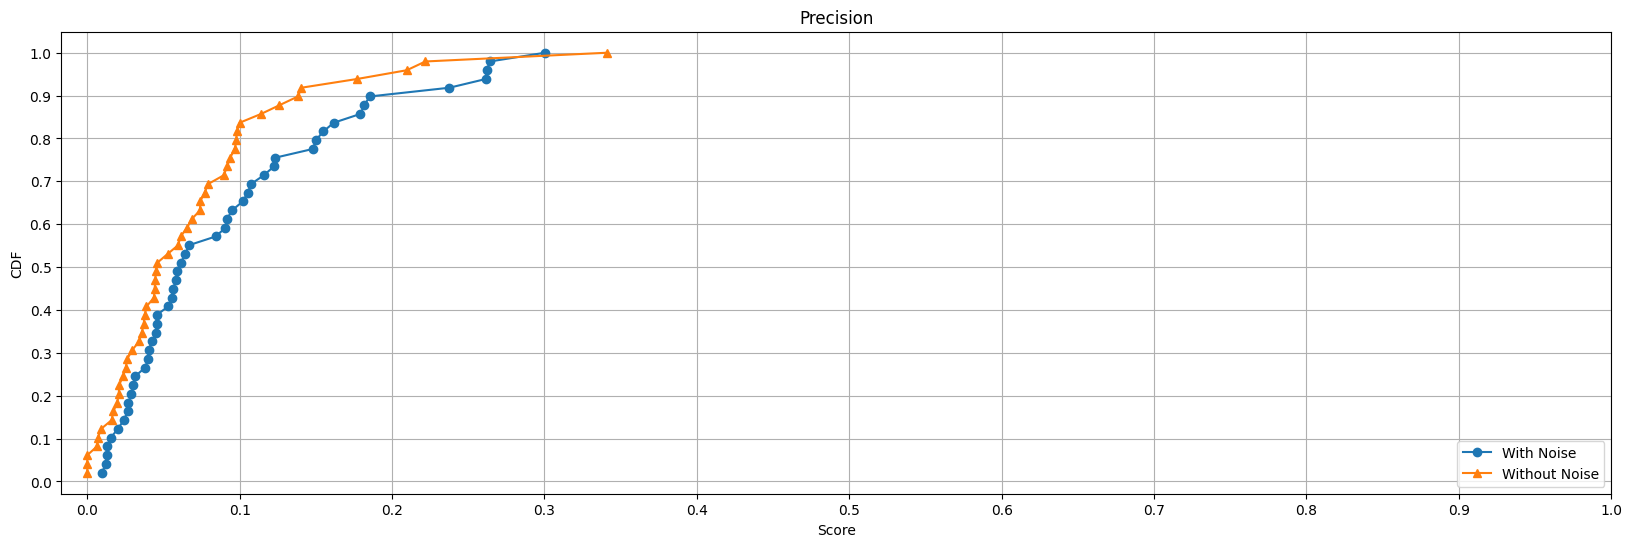

In [31]:
plot_cdf([precisions, cleaned_precisions], ["With Noise", "Without Noise"], "Precision")

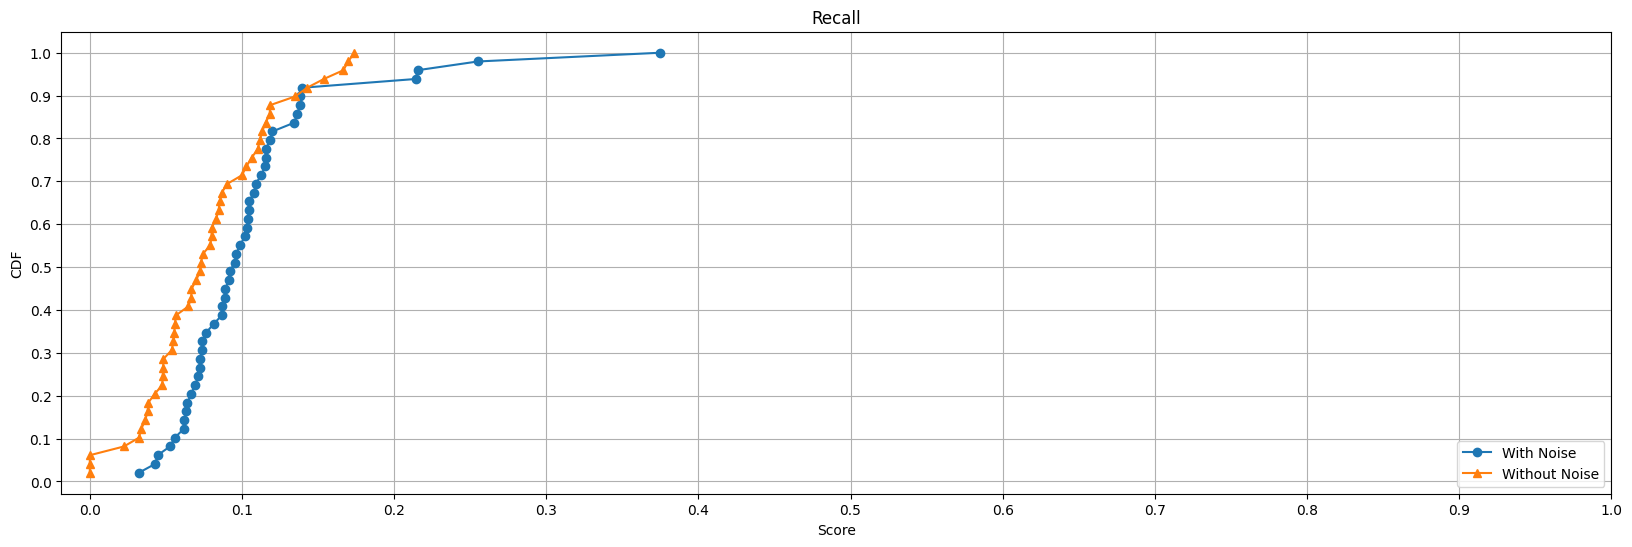

In [32]:
plot_cdf([recalls, cleaned_recalls], ["With Noise", "Without Noise"], "Recall")

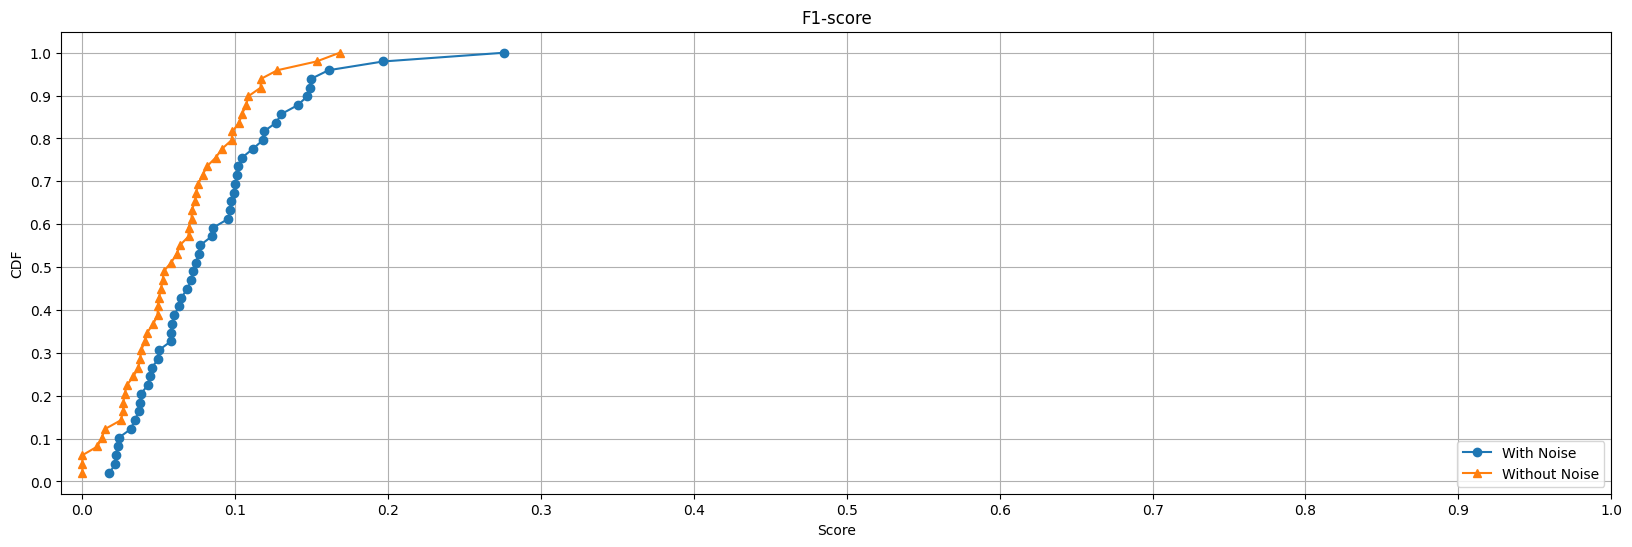

In [33]:
plot_cdf([fscores, cleaned_fscores], ["With Noise", "Without Noise"], "F1-score")

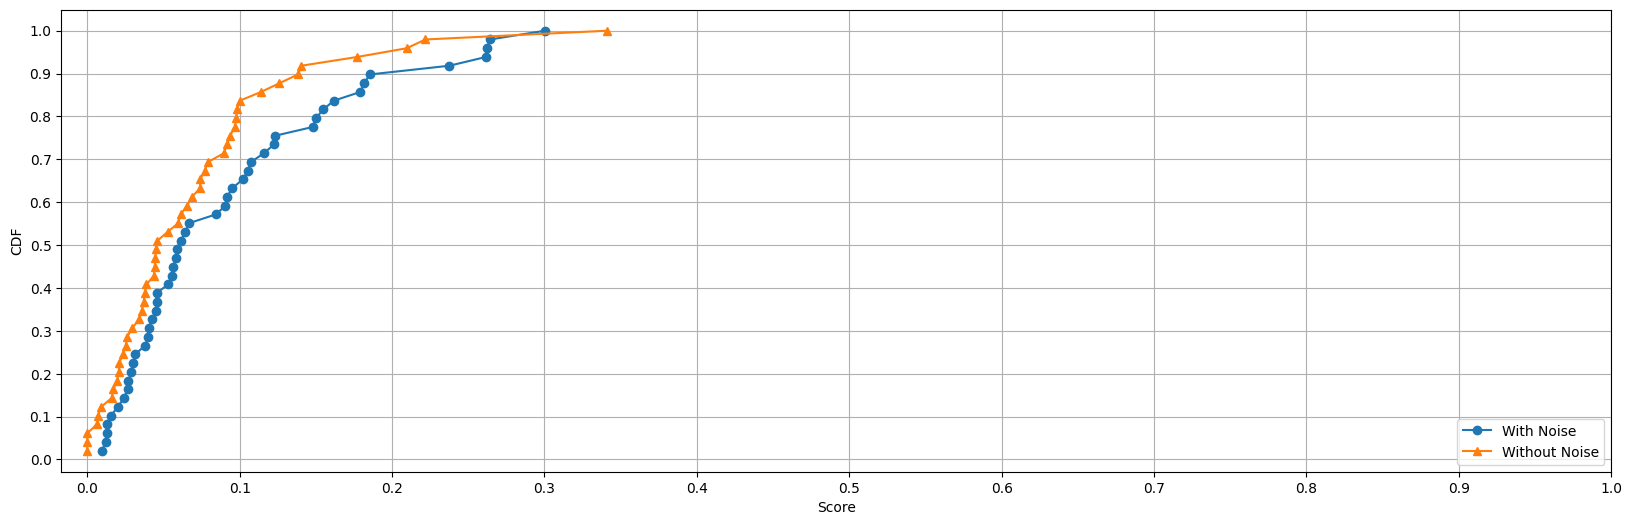

In [29]:
plot_cdf([precisions, cleaned_precisions], ["With Noise", "Without Noise"])

In [38]:
print('With Noise')
print(f"Accuracy: {np.mean(acc):.4f} ± {np.std(acc):.4f}")
print(f"Micro Precision: {np.mean(precision_micro):.4f} ± {np.std(precision_micro):.4f}")
print(f"Micro Recall: {np.mean(recall_micro):.4f} ± {np.std(recall_micro):.4f}")
print(f"Macro Precision: {np.mean(precision_macro):.4f} ± {np.std(precision_macro):.4f}")
print(f"Macro Recall: {np.mean(recall_macro):.4f} ± {np.std(recall_macro):.4f}")
print(f"Weighted Precision: {np.mean(precision_weighted):.4f} ± {np.std(precision_weighted):.4f}")
print(f"Weighted Recall: {np.mean(recall_weighted):.4f} ± {np.std(recall_weighted):.4f}")
print(f"ROC: {np.mean(roc):.4f} ± {np.std(roc):.4f}")

With Noise
Accuracy: 0.9038 ± 0.0373
Micro Precision: 0.9038 ± 0.0373
Micro Recall: 0.9038 ± 0.0373
Macro Precision: 0.5215 ± 0.0223
Macro Recall: 0.5265 ± 0.0277
Weighted Precision: 0.9099 ± 0.0655
Weighted Recall: 0.9038 ± 0.0373
ROC: 0.5265 ± 0.0277


In [39]:
print('Without Noise')
print(f"Accuracy: {np.mean(cleaned_acc):.4f} ± {np.std(acc):.4f}")
print(f"Micro Precision: {np.mean(cleaned_precision_micro):.4f} ± {np.std(cleaned_precision_micro):.4f}")
print(f"Micro Recall: {np.mean(cleaned_recall_micro):.4f} ± {np.std(cleaned_recall_micro):.4f}")
print(f"Macro Precision: {np.mean(cleaned_precision_macro):.4f} ± {np.std(cleaned_precision_macro):.4f}")
print(f"Macro Recall: {np.mean(cleaned_recall_macro):.4f} ± {np.std(cleaned_recall_macro):.4f}")
print(f"Weighted Precision: {np.mean(cleaned_precision_weighted):.4f} ± {np.std(cleaned_precision_weighted):.4f}")
print(f"Weighted Recall: {np.mean(cleaned_recall_weighted):.4f} ± {np.std(cleaned_recall_weighted):.4f}")
print(f"ROC: {np.mean(cleaned_roc):.4f} ± {np.std(cleaned_roc):.4f}")

Without Noise
Accuracy: 0.9391 ± 0.0373
Micro Precision: 0.9391 ± 0.0292
Micro Recall: 0.9391 ± 0.0292
Macro Precision: 0.5192 ± 0.0211
Macro Recall: 0.5226 ± 0.0210
Weighted Precision: 0.9433 ± 0.0479
Weighted Recall: 0.9391 ± 0.0292
ROC: 0.5226 ± 0.0210


In [48]:
get_result()

,Metric,With Noise (Mean),With Noise (Std),Without Noise (Mean),Without Noise (Std)
0,Accuracy,0.903799,0.037254,0.939096,0.029164
1,Precision,0.092775,0.075873,0.068891,0.064450
2,Recall,0.104917,0.057466,0.077730,0.042212
3,F1 Score,0.083884,0.050025,0.062890,0.038450
4,Micro Precision,0.903799,0.037254,0.939096,0.029164
5,Micro Recall,0.903799,0.037254,0.939096,0.029164
6,Macro Precision,0.521488,0.022257,0.519185,0.021050
7,Macro Recall,0.526490,0.027690,0.522573,0.021036
8,Weighted Precision,0.909947,0.065503,0.943286,0.047933
9,Weighted Recall,0.903799,0.037254,0.939096,0.029164
